<a href="https://colab.research.google.com/github/kylemath/eeg-notebooks/blob/master/notebooks/CueingAnalysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CueingAnalysis_SingleSubject_Colab


# Cueing

The cueing task can ellicit a number of reliable changes. A central cue indicates the location of an upcoming target onset. Here the task can be changed to be perfectly predictive, or have some level of cue validity. Task is to indicate the orientation of a spatial grating on the target, up for vertical, right for horizontal.

ERP - Validly cued targets ellict larger ERP's than invalidly cued targets

Response ERPs - Validly cued targets are more quickly identified and better identified

Oscillations - Alpha power lateralizes after a spatial cue onset preceeding the upcoming onset of a target. Alpha power becomes smaller contraleral to the target side, and larger ipsilateral with the target.

In [1]:
!git clone https://github.com/kylemath/eeg-notebooks --recurse-submodules
%cd eeg-notebooks/notebooks


Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 2183 (delta 37), reused 33 (delta 14), pack-reused 2113
Receiving objects: 100% (2183/2183), 163.65 MiB | 20.26 MiB/s, done.
Resolving deltas: 100% (931/931), done.
Checking out files: 100% (641/641), done.
/content/eeg-notebooks/notebooks


In [14]:
!pip install mne
from mne import Epochs, find_events
from mne.time_frequency import tfr_morlet
import numpy as np
import os
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches


# Prepare the Data for Analysis
Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the cueing effects

Load data into MNE objects
MNE is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step after loading dependencies is use MNE to read the data we've collected into an MNE Raw object

In [3]:
sub = 302
raw = utils.load_data('visual/cueing', sfreq=256., 
                      subject_nb=sub, session_nb=1,
                      )
raw.append(
      utils.load_data('visual/cueing', sfreq=256., 
                      subject_nb=sub, session_nb=2,
                      )
          )

Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.


Plot raw data

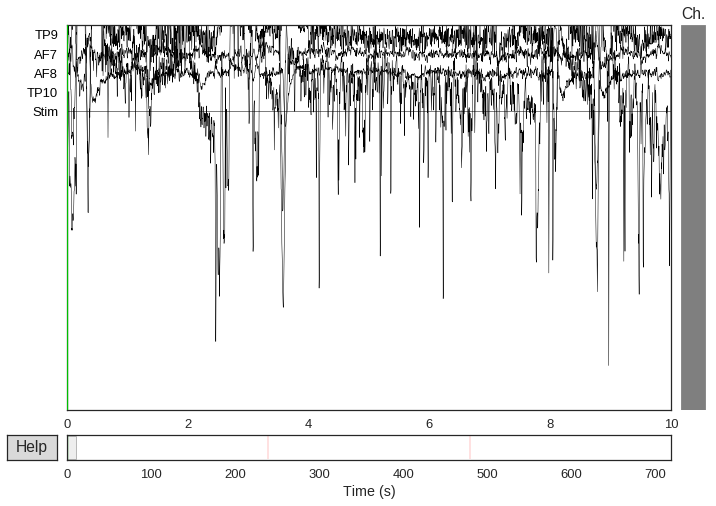

In [5]:
raw.plot();

# Power Spectral Density
One way to analyze the SSVEP is to plot the power spectral density, or PSD. SSVEPs should appear as peaks in power for certain frequencies. We expect clear peaks in the spectral domain at the stimulation frequencies of 30 and 20 Hz.

Effective window size : 8.000 (s)


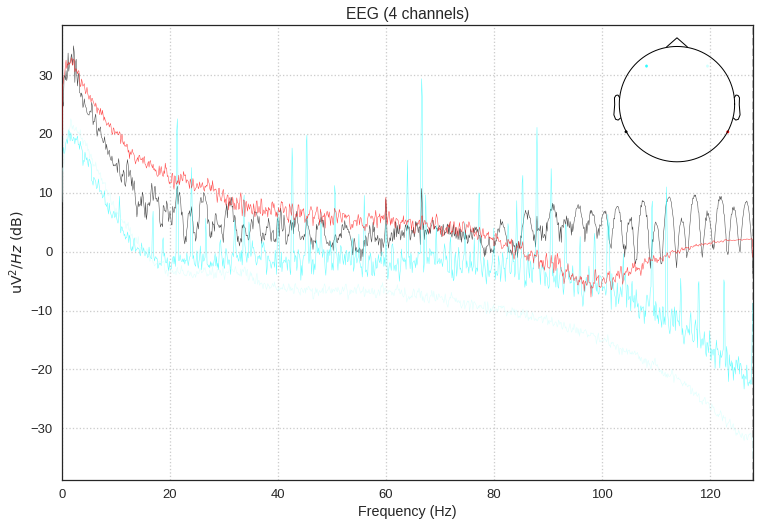

In [6]:
raw.plot_psd();

Should see the electrical noise at 60 Hz, and maybe a peak at the red and blue channels between 7-14 Hz (Alpha)



# Filtering
Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Using filter length: 61296
Setting up band-pass filter from 1 - 30 Hz
Using filter length: 61296
Setting up band-pass filter from 1 - 30 Hz
Using filter length: 61296
Effective window size : 8.000 (s)


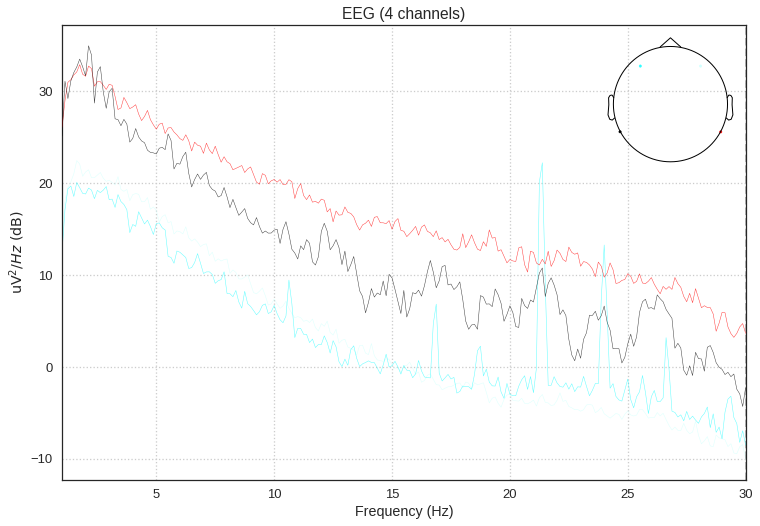

In [7]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

# Epoching
Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

213 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  95.77464788732395


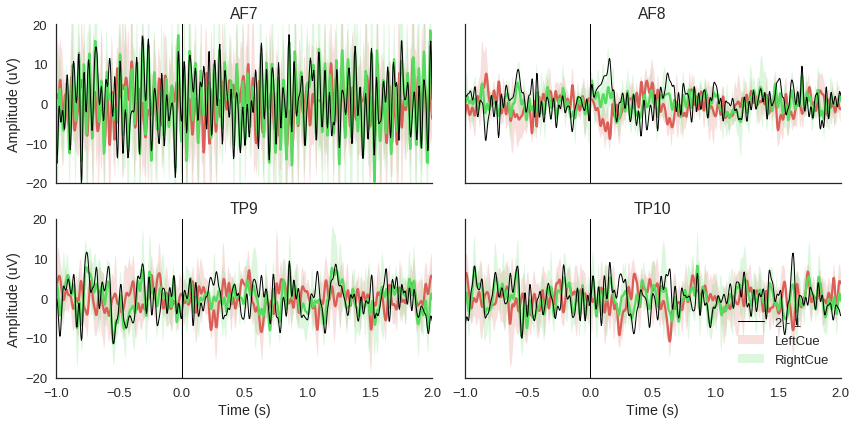

In [11]:
events = find_events(raw)
event_id = {'LeftCue': 1, 'RightCue': 2}

rej_thresh_uV = 150
rej_thresh = rej_thresh_uV*1e-6

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-1, tmax=2, baseline=(-1, 0), 
                reject={'eeg':rej_thresh}, preload=True,
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

conditions = OrderedDict()
conditions['LeftCue'] = [1]
conditions['RightCue'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-20,20))

# Spectrogram
We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time


Applying baseline correction (mode: mean)
No baseline correction applied


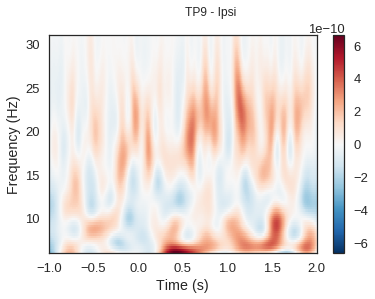

No baseline correction applied


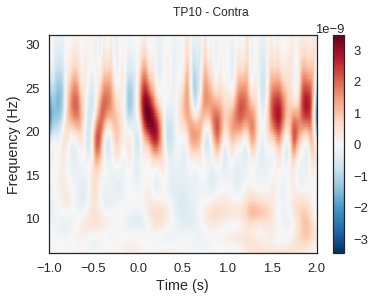

Applying baseline correction (mode: mean)
No baseline correction applied


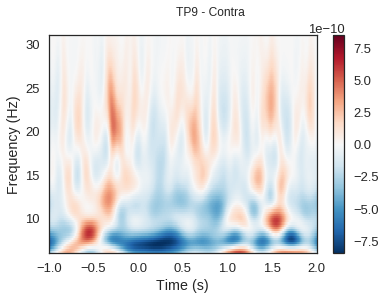

No baseline correction applied


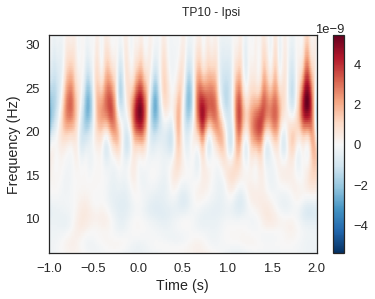

In [13]:
frequencies =  np.linspace(6, 30, 100, endpoint=True)

wave_cycles = 6

 # Compute morlet wavelet

# Left Cue
tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=True)
tfr = tfr.apply_baseline((-1,-.5),mode='mean')
tfr.plot(picks=[0], mode='logratio', 
         title='TP9 - Ipsi');
tfr.plot(picks=[1], mode='logratio', 
         title='TP10 - Contra');
power_Ipsi_TP9 = tfr.data[0,:,:]
power_Contra_TP10 = tfr.data[1,:,:]

# Right Cue
tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=True)
tfr = tfr.apply_baseline((-1,-.5),mode='mean')
tfr.plot(picks=[0], mode='logratio', 
         title='TP9 - Contra');
tfr.plot(picks=[1], mode='logratio', 
         title='TP10 - Ipsi');
power_Contra_TP9 = tfr.data[0,:,:]
power_Ipsi_TP10 = tfr.data[1,:,:]

# Now we compute and plot the differences



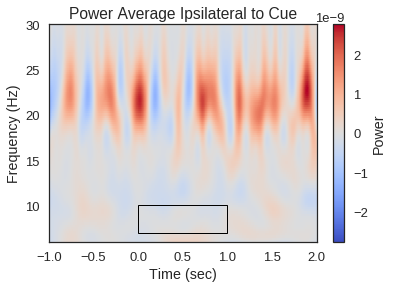

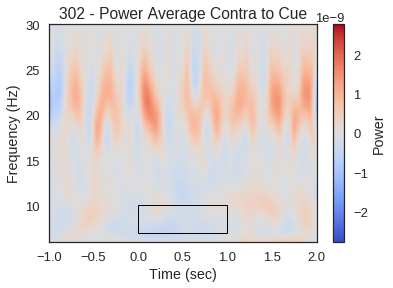

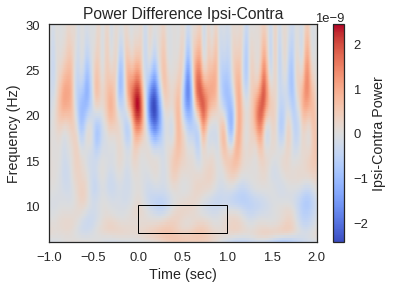

In [15]:
# time frequency window for analysis
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

# Plot Differences
%matplotlib inline
times = epochs.times
power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;


#find max to make color range
plot_max = np.max([np.max(np.abs(power_Avg_Ipsi)), np.max(np.abs(power_Avg_Contra))])
plot_diff_max = np.max(np.abs(power_Avg_Diff))

#Ipsi
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Ipsi,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Average Ipsilateral to Cue')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#TP10
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Contra,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title(str(sub) + ' - Power Average Contra to Cue')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#difference between conditions
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Diff,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Difference Ipsi-Contra')
cb = fig.colorbar(im)
cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

We expect greater alpha power ipsilateral to the cue direction (positive values) from 0 to 1.5 seconds

# Target Epoching
Next, we will chunk (epoch) the data into segments representing the data .200ms before to 1000ms after each target, we will reject every epoch where the amplitude of the signal exceeded ? uV, which should most eye blinks.



213 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  90.61032863849765


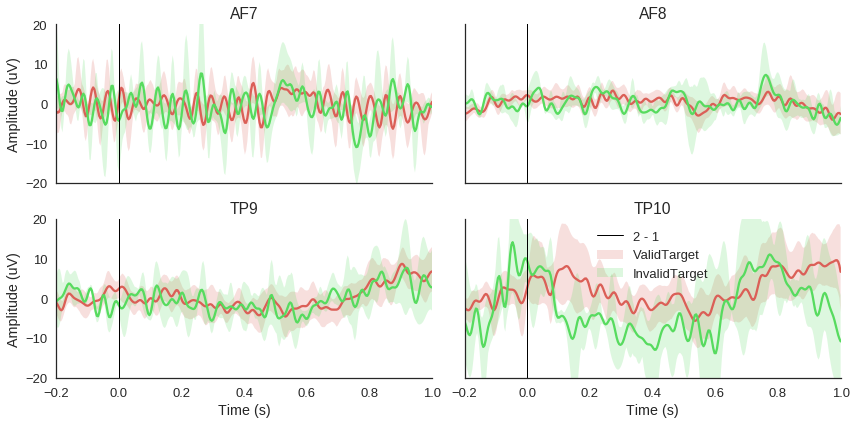

In [16]:
events = find_events(raw)
event_id = {'InvalidTarget_Left': 11, 'InvalidTarget_Right': 12,
           'ValidTarget_Left': 21,'ValidTarget_Right': 11}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-.2, tmax=1, baseline=(-.2, 0), 
                reject={'eeg':.0001}, preload=True,
                verbose=False, picks=[0, 1, 2, 3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

%matplotlib inline
conditions = OrderedDict()
conditions['ValidTarget'] = [21,22]
conditions['InvalidTarget'] = [11,12]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-20,20))